In [27]:
#%reset -f -s

In [28]:
'''------------------------------------------------------------------
---------------------------------------------------------------------
LSTM Training
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
from pathlib import Path

# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "TORCH_SEED"  :     7,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", 
                         "bs_brk_cval", "elcomp_pwrcons_cval","epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 
                         'brktempra_cval', 'selgr_rq_pt'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      400,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.5,
    "SEQ_LENGTH":       60,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       10,
    "BATCH_SIZE":       16,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    2e-3,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)",      
                            # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                            # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                            # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-7)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", #['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']


    # METRICS: ---------------------------------------------------------------------

    # SAVE & LOAD: -----------------------------------------------------------------

}

for key in CONFIG: globals()[key] = CONFIG[key]
print(f"ROOT: {ROOT}")

ROOT: /home/sieglew/MA-eR-PINN


___
LOCATE DEVICES & SYSTEM FOLDERS

In [29]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
global ROOT, DATA_PATH
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.TripDataset import *
from src.utils.train_model import *

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32); torch.manual_seed(TORCH_SEED);

from sklearn.metrics import root_mean_squared_error
from pytorch_forecasting.metrics import MASE
#from darts import TimeSeries
#from darts.models import ExponentialSmoothing

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode


In [30]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")

------------------------------------------------------------
Torch version:  2.4.1+cu121
Using: -->  CUDA:0


___
DATA PREPROCESSING

In [31]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files[:MAX_FILES]
print(f"{'-'*60}\nTotal Files:\t{len(files)}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 44

# FILTER INPUT FILES --------------------------------------------------------
# generate lengths of all files by reading metadata or using presaved lengths
try:
    presaved_lengths = pd.read_pickle(Path(ROOT, 'data', 'df_files_lengths.pickle'))
    presaved_lengths = presaved_lengths.set_index('FileName').to_dict()['Length']
    trip_lengths = [presaved_lengths[file.name] for file in files]
except:
    print(f"{'-'*60}\nObtaining sequence lengths... (may take up to 5 minutes)")
    trip_lengths = [pq.read_metadata(file).num_rows for file in files]

# discard all items shorter than min_seq_length
min_seq_length = 400
filtered_files = []
filtered_lengths = []
for file, length in zip(files, trip_lengths):
    if length > min_seq_length: 
        filtered_files.append(file)
        filtered_lengths.append(length)

# replace lists with only filtered items
files = filtered_files
trip_lengths = filtered_lengths
print(f"Filtered Files:\t{len(files)}\n{'-'*60}")

# SORT INPUT FILES BY SEQUENCE LENGTH --------------------------------------
# this is needed in order to later sort the sequence by their length
file_length_mapping = sorted([(file.name, length, idx) for idx, (file, length) in enumerate(zip(files, trip_lengths))], \
    key=lambda x: x[1], reverse=True)

file_length_df = pd.DataFrame(file_length_mapping, columns=['FileName', 'Length', 'Index'])
print(file_length_df)

indices_by_length = file_length_df['Index'].to_list()
sorted_trip_lengths = file_length_df['Length'].to_list()

------------------------------------------------------------
Input Data:	/home/sieglew/MA-Data/TripSequences/trips_processed_final
Store model in:	/home/sieglew/MA-eR-PINN/src/models/pth
------------------------------------------------------------
Total Files:	18629
Filtered Files:	15024
------------------------------------------------------------
                FileName  Length  Index
0        V13_T25.parquet   20843   1920
1       V18_T775.parquet   19425   5702
2       V13_T352.parquet   18308   1869
3       V18_T972.parquet   17858   7531
4      V16_T1629.parquet   17519   3804
...                  ...     ...    ...
15019   V17_T975.parquet     402   6782
15020    V1_T214.parquet     402  13653
15021  V16_T1274.parquet     401    813
15022   V18_T761.parquet     401   4795
15023  V14_T1237.parquet     401  13221

[15024 rows x 3 columns]


In [32]:
%%skip
def plot_sequence_lengths(batch_size, trip_lengths):
    # Calculate the number of batches
    num_batches = int(np.ceil(len(trip_lengths) / batch_size))
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(18, 6))
    ratios = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(trip_lengths))
        batch_lengths = trip_lengths[start_idx:end_idx]

        ax.bar(range(start_idx, end_idx), batch_lengths, color='blue', edgecolor='blue') # Plot the actual sequence lengths

        max_length = max(batch_lengths)
        blue_area = sum(batch_lengths)
        orange_area = sum(max_length - length for length in batch_lengths)
        ratio = orange_area / (blue_area + orange_area)
        ratios.append(ratio)

        # Highlight the padded parts
        for j in range(start_idx, end_idx): ax.bar(j, max_length - batch_lengths[j - start_idx], bottom=batch_lengths[j - start_idx], color='orange', edgecolor='orange')

        # Add vertical red dashed lines at batch boundaries
        if i > 0: ax.axvline(x=start_idx, color='red', linestyle='--')

    # Set labels and title
    ax.set_xlabel('Sequence Number')
    ax.set_ylabel('Sequence Length (Number of Rows)')
    ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
    handles = [plt.Rectangle((0,0),1,1,color=c,ec="k") if c != "red" else plt.Line2D([0], [0], color=c, linestyle='--') for c in ["blue", "orange", "red"]]
    labels = ["sequence data", "padding", "batch boundaries"]
    ax.legend(handles, labels, loc="upper right"); ax.grid(False); plt.show();

    return ratios

ratios_1 = plot_sequence_lengths(BATCH_SIZE, trip_lengths)
ratios_2 = plot_sequence_lengths(BATCH_SIZE, sorted_trip_lengths)

# Calculate and print the ratio between blue and orange areas for both diagrams
print(f"padding values (unsorted) = {np.mean(ratios_1)*100:.0f} %")
print(f"padding values (sorted) = {np.mean(ratios_2)*100:.0f} %")

In [33]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
"hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "hirestotalvehdist_cval_icuc"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

# FEATURE SELECTION  --------------------------------------
# ---------------------------------------------------------
target_column = TARGETS
input_columns = FEATURES
input_columns = list(set(all_signals) - set(columns_to_drop) - set(target_column))

In [34]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])

# DATA SET SPLITTING -----------------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

In [ ]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
'''
Notes: for each of the three subsets, the following steps are performed:
    1. Sort each subset by descending sequence lengths based on the obtained indices
    2. Create a (custom) TripDataset object to select the input and target columns and apply the scalers. In case
         of the training subset, the scalers will be fitted to the training set first.
    3. Create a (custom) BatchDataset object of the corresponding TripDataset to handle the sequence padding before using 
            the DataLoader to create the batches.
    4. The DataLoader will then be used to iterate over the batches during training. To use the integrated collate_fn function
            of the DataLoader, the batch_size has to be set to 1. The actual batch size is then handled by the BatchDataset object.
    5. The collate_fn that is integrated in the DataLoader will automatically handle the shuffling, padding and packing
            of the sequences. The DataLoader will return a tuple of (packed_inputs, padded_targets, lengths), where
            the packed_inputs are PackedSequence objects that can be efficiently processed by RNNs.
            [Output tuple of types (<class 'torch.nn.utils.rnn.PackedSequence'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>)]

Note: shuffling will be done batchwise, however inside each batch the sequences  will remain sorted by length

*Note: Because of the BatchDataset object in the train loader, "batch_size" refers to the number of batches to feed, not the 
number of samples in a batch. Also, the "drop_last" argument is useless due to this.
'''

# -------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                # see *Note above
    'shuffle': True,                # shuffle the batches before each epoch
    'collate_fn': collate_fn,       # include optional arguments
    'num_workers': 4,               # number of workers
    'pin_memory': False if DEVICE.type == 'cpu' else True
}

# TRAIN  ------------------------------------------------------------
train_subset.indices = [i for i in indices_by_length if i in set(list(train_subset.indices))]
train_dataset = TripDataset(train_subset, input_columns, target_column, scaler, target_scaler, fit=True)
train_dataset_batches = create_batches(train_dataset, BATCH_SIZE)
train_loader = DataLoader(train_dataset_batches, **dataloader_settings)

# VAL --------------------------------------------------------------
val_subset.indices = [i for i in indices_by_length if i in set(list(val_subset.indices))]
val_dataset = TripDataset(val_subset, input_columns, target_column, scaler, target_scaler, fit=False)
val_dataset_batches = create_batches(val_dataset, BATCH_SIZE)
val_loader = DataLoader(val_dataset_batches, **dataloader_settings)

# TEST -------------------------------------------------------------
test_subset.indices = [i for i in indices_by_length if i in set(list(test_subset.indices))]
test_dataset = TripDataset(test_subset, input_columns, target_column, scaler, target_scaler, fit=False)
test_dataset_batches = create_batches(test_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset_batches, **dataloader_settings)

fitting Scalers: MaxAbsScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...


In [ ]:
# Print the size of the datasets ----------------------------------
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)}) \n {"-"*60}')
if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")

subset_files = {"train":    list(train_dataset.file_list),
                "val":      list(val_dataset.file_list),
                "test":     list(test_dataset.file_list)}
print(f"first 3 train files: {[os.path.basename(_) for _ in subset_files['train'][:3]]}")

------------------------------------------------------------
Train size:  9009694		(Files: 2109)
Val. size:   1666855		(Files: 396)
Test size:   499588		(Files: 131) 
 ------------------------------------------------------------
first 3 train files: ['V13_T25.parquet', 'V16_T1629.parquet', 'V101_T37.parquet']


In [ ]:
%%skip
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))
ratios = []
for batch_idx, (padded_inputs, padded_targets, lengths) in enumerate(train_loader):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = start_idx + len(lengths)
    
    # Plot the actual sequence lengths
    ax.bar(range(start_idx, end_idx), lengths, color='blue', edgecolor='blue')
    
    # Highlight the padded parts
    max_length = max(lengths)
    blue_area = sum(lengths)
    orange_area = sum(max_length - length for length in lengths)
    ratio = orange_area / (blue_area + orange_area)
    ratios.append(ratio)

    for j in range(start_idx, end_idx): ax.bar(j, max_length - lengths[j - start_idx], bottom=lengths[j - start_idx], color='orange', edgecolor='orange')

    # Add vertical red dashed lines at batch boundaries
    if batch_idx > 0: ax.axvline(x=start_idx, color='red', linestyle='--')

# Set labels and title
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Sequence Length (Number of Rows)')
ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
handles = [plt.Rectangle((0,0),1,1,color=c,ec="k") if c != "red" else plt.Line2D([0], [0], color=c, linestyle='--') for c in ["blue", "orange", "red"]]
labels = ["sequence data", "padding", "batch boundaries"]
ax.legend(handles, labels, loc="upper right"); ax.grid(False); plt.show(); 

# Calculate and print the ratio between blue and orange areas
print(f"padding values = {np.mean(ratios)*100:.0f} %")

In [ ]:
# Iterate through the train_loader and print an example of a PackedSequence
for batch_idx, (packed_inputs, padded_targets, lengths) in enumerate(train_loader):
    #print(f"Packed Inputs (Batch {batch_idx}):\n{packed_inputs}")
    print(f"Type of packed_inputs: {type(packed_inputs)}, Type of packed_inputs.data: {type(packed_inputs.data)}, Type of packed_inputs.batch_sizes: {type(packed_inputs.batch_sizes)}")
    print(f"Type of padded_targets: {type(padded_targets)}, Type of lengths: {type(lengths)}")
    print(f"Shape of packed_inputs.data: {packed_inputs.data.shape}")
    print(f"Length of packed_inputs.batch_sizes: {len(packed_inputs.batch_sizes)}")
    print(f"Lengths: {lengths}")
    print(sum(lengths))
    break

Type of packed_inputs: <class 'torch.nn.utils.rnn.PackedSequence'>, Type of packed_inputs.data: <class 'torch.Tensor'>, Type of packed_inputs.batch_sizes: <class 'torch.Tensor'>
Type of padded_targets: <class 'torch.Tensor'>, Type of lengths: <class 'torch.Tensor'>
Shape of packed_inputs.data: torch.Size([23041, 40])
Length of packed_inputs.batch_sizes: 1445
Lengths: tensor([1445, 1445, 1444, 1444, 1444, 1443, 1440, 1440, 1439, 1439, 1439, 1438,
        1437, 1436, 1434, 1434])
tensor(23041)


In [ ]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1_packed(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, dropout, device=DEVICE):
        super(LSTM1_packed, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout
        self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first=True,           # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias=True,                  # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout=self.dropout,       # usually: [0.2 - 0.5], introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional=False,        # If True, becomes a bidirectional LSTM. Default: False
            proj_size=0,                # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device=device
        )

        self.relu = nn.ReLU()
        self.fc_test = nn.Linear(hidden_size, 1)
    
    def forward(self, packed_input, batch_size=None):
        # Propagate input through LSTM
        packed_out, _ = self.lstm(packed_input)
        #print(f"LSTM: Output after LSTM: {packed_out.data.shape}, {type(packed_out)}")

        # Unpack the output
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        #print(f"             after packing: {out.shape}, {type(out)}")

        # Output layers
        out = self.relu(out)  # relu
        #print(f"             after relu: {out.shape}, {type(out)}")

        out = self.fc_test(out)  # Use all outputs for prediction
        #print(f"             after fc: {out.shape}, {type(out)}")
        
        return out


In [ ]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = HIDDEN_SIZE           # features in the hidden state h
num_layers = NUM_LAYERS             # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1_packed(input_size, HIDDEN_SIZE, NUM_LAYERS, SEQ_LENGTH, DROPOUT).to(DEVICE)
print(f"{'-'*60}\n", model)
print(f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}") 
# --> Note torch.Size([4*hidden_size, input_size]) for LSTM weights because of i,o,f,g params concatenated

------------------------------------------------------------
 LSTM1_packed(
  (lstm): LSTM(40, 400, num_layers=2, batch_first=True, dropout=0.5)
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
)
------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([1600, 40])
lstm.weight_hh_l0:	 torch.Size([1600, 400])
lstm.bias_ih_l0:	 torch.Size([1600])
lstm.bias_hh_l0:	 torch.Size([1600])
lstm.weight_ih_l1:	 torch.Size([1600, 400])
lstm.weight_hh_l1:	 torch.Size([1600, 400])
lstm.bias_ih_l1:	 torch.Size([1600])
lstm.bias_hh_l1:	 torch.Size([1600])
fc_test.weight:	 torch.Size([1, 400])
fc_test.bias:	 torch.Size([1])


In [ ]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER -----------------------------
# common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
if 'OPTIMIZER' in globals(): optimizer = eval(OPTIMIZER)
else: optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
        weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
        #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LR SCHEDULER -----------------------------
if 'LRSCHEDULER' in globals(): scheduler = eval(LRSCHEDULER)
else: scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

if 'CRITERION' in globals(): criterion = eval(CRITERION)
else: criterion = nn.SmoothL1Loss()

# ------------------------------------------------------------------------------
# print Model and Optimizer state_dicts
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\n")

------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0.0001
)
------------------------------------------------------------



In [ ]:
'''
######################## 
# ------------->  TO BE INCLUDED IN train_model.py'''

if torch.cuda.is_available(): from torch.amp import GradScaler, autocast
#############################################################################################################
# -----------------------------------------------------------------------------------------------------------

class Trainer_packed():

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, 
                 train_loader: DataLoader, num_epochs: int, device: torch.device, 
                 is_notebook: bool = False, val_loader: DataLoader = None, test_loader: DataLoader = None, 
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None, state: dict = None, 
                 use_mixed_precision: bool = False, clip_value = None):

        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.num_epochs = num_epochs
        self.device = device
        self.is_notebook = is_notebook
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.scheduler = scheduler
        self.state = state
        self.use_mixed_precision = use_mixed_precision if torch.cuda.is_available() else False
        if self.use_mixed_precision: self.scaler = GradScaler('cuda')  # Initialize GradScaler
        self.clip_value = clip_value

    # EVALUATION ROUTINE DEFINITION -----------------------------------------------------------------
    def evaluate_model(self) -> tuple:
        if self.test_loader is None: print("No test data available."); return None
        else:
            self.model.eval()  # Set model to evaluation mode
            test_loss = 0.0
            all_outputs, all_targets, all_original_lengths = [], [], []

            with torch.no_grad():
                for inputs, targets, original_lengths in self.test_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    # -------------------------------------
                    if self.use_mixed_precision:
                        with autocast(device_type='cuda'):
                            outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                            outputs = outputs.squeeze()
                            if outputs.dim() > 1:
                                mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]
                            else:
                                print("shape: ", outputs.shape), print(outputs.size(0), outputs.size(1))
                            outputs_masked = outputs[mask]
                            targets_masked = targets[mask]
                            loss = self.loss_fn(outputs_masked.squeeze(), targets_masked).mean()
                            test_loss += loss.item()
                    else:
                        outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                        outputs = outputs.squeeze()
                        mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]
                        outputs_masked = outputs[mask]
                        targets_masked = targets[mask]
                        loss = self.loss_fn(outputs_masked.squeeze(), targets_masked).mean()
                        test_loss += loss.item()
                    # -------------------------------------
                    # Detach tensors from the computation graph and move them to CPU
                    outputs = outputs.detach().cpu().numpy()
                    targets = targets.detach().cpu().numpy()
                    # Remove the padded endings of each sequence and restore their original lengths
                    unpadded_outputs = [output[:length] for output, length in zip(outputs, original_lengths)]
                    unpadded_targets = [target[:length] for target, length in zip(targets, original_lengths)]
                    # -------------------------------------
                    # Collect all outputs and targets
                    all_outputs.append(unpadded_outputs)
                    all_targets.append(unpadded_targets)
                    all_original_lengths.append(original_lengths.detach().cpu().numpy())
            # -------------------------------------
            test_loss /= len(self.test_loader)  # Calculate average test loss
            return test_loss, all_outputs, all_targets, all_original_lengths

    # VALIDATION ROUTINE DEFINITION -----------------------------------------------------------------
    def validate_model(self, epoch: int) -> float:
        if self.val_loader is None: print("No validation data available."); return None
        else:
            self.model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():  # Disable gradient calculation
                for inputs, targets, original_lengths in self.val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    # -------------------------------------
                    if self.use_mixed_precision:
                        with autocast(device_type='cuda'):
                            outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                            outputs = outputs.squeeze()
                            mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]
                            outputs = outputs[mask]
                            targets = targets[mask]
                            loss = self.loss_fn(outputs.squeeze(), targets).mean()
                            val_loss += loss.item()
                    else:
                        outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                        outputs = outputs.squeeze()
                        mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]
                        outputs = outputs[mask]
                        targets = targets[mask]
                        loss = self.loss_fn(outputs.squeeze(), targets).mean()
                        val_loss += loss.item()
            # -------------------------------------          
            val_loss /= len(self.val_loader)  # Calculate average validation loss
            if self.scheduler:
                lr1 = self.scheduler.get_last_lr()[0]
                self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss
                lr2 = self.scheduler.get_last_lr()[0]
                self.lr_history.append(lr2)
                if lr1 != lr2: print(f"Learning rate updated after epoch {epoch}: {lr1} -> {lr2}")
            return val_loss

    # TRAINING ROUTINE DEFINITION -----------------------------------------------------------------
    def train_model(self) -> dict:
       # output info on training process
        print(f"{'-'*60}\nTraining Started.\tProcess ID: {os.getpid()} \n{'-'*60}\n"
              f"Model: {self.model.__class__.__name__}\t\tParameters on device: {str(next(self.model.parameters()).device).upper()}\n{'-'*60}\n"
              f"Train/Batch size:\t{len(self.train_loader.dataset)} / {self.train_loader.batch_size}\n"
              f"Loss:\t\t\t{self.loss_fn}\nOptimizer:\t\t{self.optimizer.__class__.__name__}\nLR:\t\t\t"
              f"{self.optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{self.optimizer.param_groups[0]['weight_decay']}\n{'-'*60}")
        
        # Load state dict if provided
        start_epoch = 1
        if self.state:
            self.model.load_state_dict(self.state['model_state_dict'])
            self.optimizer.load_state_dict(self.state['optimizer_state_dict'])
            self.train_losses = self.state['train_losses']
            self.train_losses_per_iter = self.state['train_losses_per_iter']
            self.lr_history = self.state['lr_history']
            self.val_losses = self.state['val_losses']
            self.training_table = self.state['training_table']
            start_epoch = self.state['epoch'] + 1
        else:
            self.train_losses = [] 
            self.train_losses_per_iter = []
            self.val_losses = []  
            self.training_table = []  
            self.lr_history = []
            if self.is_notebook: display_html(HTML(initialize_table()))

        # TRAINING LOOP:
        start_time = time.perf_counter()
        for epoch in range(start_epoch, self.num_epochs + 1):
            self.model.train()  # set model to training mode
            running_loss = 0.0
            num_iterations = math.ceil(len(self.train_loader.dataset) / self.train_loader.batch_size)
            header_printed = False

            tqdm_version = tqdm_nb if self.is_notebook else tqdm
            with tqdm_version(enumerate(self.train_loader, 1), unit="batch", total=num_iterations, leave=False) as tepoch:
                for iter, (inputs, targets, original_lengths) in tepoch:  # ----> note: (packed_inputs, padded_targets, lengths)
                    tepoch.set_description(f"Epoch {epoch}/{self.num_epochs}")
                    print("Dataloader: ", type(inputs), type(targets), type(original_lengths))
                    print(f"Shape of inputs: {inputs.data.shape}, {type(inputs)}")
                    print(f"Shape of targets: {targets.shape}, {type(targets)}")
                    print(f"Shape of original_lengths: {original_lengths.shape}, {type(original_lengths)}")
                    # -------------------------------------------------------------
                    # Move data to the GPU
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # zero gradients -> forward pass -> obtain loss function -> apply backpropagation -> update weights:
                    self.optimizer.zero_grad()

                    # A) use mixed precision calculation ------------------------------------------------------------------------------
                    if self.use_mixed_precision:
                        with autocast(device_type='cuda'):  # Enable autocast for mixed precision training
                            outputs = self.model(inputs)   # inputs are packed, outputs are not ! --> see forward method in model
                            outputs = outputs.squeeze()
                            mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]
                            outputs = outputs[mask]
                            targets = targets[mask]
                            loss = self.loss_fn(outputs.squeeze(), targets).mean()
                        self.scaler.scale(loss).backward()  # Scale the loss and perform backward pass
                        if self.clip_value is not None:
                            nn.utils.clip_grad_value_(self.model.parameters(), clip_value=self.clip_value)  # optional: Gradient Value Clipping
                        self.scaler.step(self.optimizer)  # Update model parameters
                        self.scaler.update()  # Update the scale for next iteration

                    # B) Normal precision calculation ------------------------------------------------------------------------------
                    else:
                        print("Forwarding.")
                        outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                        # -------------------------------------
                        print(f"Shape of outputs: {outputs.shape}, {type(outputs)}")
                        outputs = outputs.squeeze()
                        mask = torch.arange(outputs.size(1))[None, :] < original_lengths[:, None]

                        print(f"Shape of mask: {mask.shape}, {type(mask)}")
                        print(f"Masking.")
                        outputs = outputs[mask]
                        targets = targets[mask]
                        # -------------------------------------
                        print(f"Shape of outputs after mask: {outputs.shape}, {type(outputs)}")
                        print(f"Shape of targets after mask: {targets.shape}, {type(targets)}")

                        loss = self.loss_fn(outputs.squeeze(), targets).mean()
                        loss.backward()
                        if self.clip_value is not None:
                            nn.utils.clip_grad_value_(self.model.parameters(), clip_value=self.clip_value)  # optional: Gradient Value Clipping
                        self.optimizer.step()

                    # -------------------------------------------------------------
                    # Update the performance table
                    if iter % (num_iterations // 4) == 0 and iter != num_iterations // 4 * 4:
                        add_row(self.training_table, f" ", f"{iter}", f"{loss.item():.6f}", " ")
                        if self.is_notebook:
                            display_html(HTML(f"""<script>addRow("", "{iter}", "{loss.item():.6f}", "");</script>"""))
                        else:
                            print_row(self.training_table)
                    elif iter == 1:
                        add_row(self.training_table, f"{epoch}/{self.num_epochs}", f"{iter}/{num_iterations}", f"{loss.item():.6f}", " ")
                        if self.is_notebook:
                            display_html(HTML(f"""<script>addRow("<b>{epoch}/{self.num_epochs}", "{iter}/{num_iterations}", "{loss.item():.6f}", "");</script>"""))
                        else:
                            print_row(self.training_table)

                    # -------------------------------------------------------------
                    # Update running loss and progress bar
                    self.train_losses_per_iter.append(loss.item())
                    running_loss += loss.item()  # accumulate loss for epoch
                    tepoch.set_postfix(loss=loss.item()); tepoch.update(1)

            # Calculate average training loss for the epoch
            avg_train_loss = running_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # Update the performance table
            add_row(self.training_table, f" ", f"{iter}", f"{loss.item():.6f}", f"{avg_train_loss:.6f}")
            if self.is_notebook:
                display_html(HTML(f"""<script>addRow("", "{iter}", "{loss.item():.6f}", "<b>{avg_train_loss:.6f}");</script>"""))
            else:
                print_row(self.training_table)

            # VALIDATION
            if self.val_loader:
                val_loss = self.validate_model(epoch)
                self.val_losses.append(val_loss)
                # Update the performance table
                add_row(self.training_table, f"Val", f"Validation Loss:", f"{val_loss:.6f}", "")
                if self.is_notebook:
                    display_html(HTML(f"""<script>addRow("<b>Val", "Validation Loss:", "<b>{val_loss:.6f}", "");</script>"""))
                else:
                    print_row(self.training_table)

        elapsed_time = round(time.perf_counter() - start_time)
        print(f"{'-'*60}\nTraining Completed.\tExecution Time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}\n{'-'*60}\n")
        return {
            # model and optimizer states
            "model": self.model,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            # training performance
            "training_table": self.training_table,
            "train_losses": self.train_losses,
            "train_losses_per_iter": list(self.train_losses_per_iter),
            "val_losses": self.val_losses,
            'lr_history': self.lr_history,
            # settings and meta data
            "loss_fn": self.loss_fn,
            "epoch": epoch,
            "elapsed_train_time": elapsed_time
        }


In [ ]:
# NETWORK TRAINING -----------------------------------------------------------------
trainer = Trainer_packed(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = True
    )
    
trained = trainer.train_model()

------------------------------------------------------------
Training Started.	Process ID: 44051 
------------------------------------------------------------
Model: LSTM1_packed		Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	132 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.003
Weight Decay:		0.0001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([28765, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1806]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([127006, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8024]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23224, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1456]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27657, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1737]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([19443, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1219]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([29619, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1868]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([21569, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1355]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([69665, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4393]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([26362, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1659]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27925, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1756]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([57109, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3605]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([184917, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 11843]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([46794, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2946]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([41334, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2605]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([47705, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3021]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([37836, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2385]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([140382, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8817]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([63572, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3997]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([22835, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1433]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([26702, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1675]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([46121, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2902]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([105821, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6700]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([24184, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1520]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([45338, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2857]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([40359, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2548]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([44359, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2798]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27925, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1756]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([61685, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3879]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([37836, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2385]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([35748, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2252]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([94389, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5980]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([21569, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1355]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([60787, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3821]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([25316, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1587]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([124749, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7875]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([42111, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2656]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23920, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1501]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([132343, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8357]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([127006, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8024]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([20520, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1292]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([28765, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1806]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([194202, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 12550]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([71198, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4491]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([140382, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8817]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([219507, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 14285]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([206589, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 13221]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([53615, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3388]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([86185, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5423]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([169324, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 10725]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([76084, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4801]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([15677, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([13, 1210]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([13]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([35748, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2252]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([98029, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6216]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([153399, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9662]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([41334, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2605]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([88034, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5573]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([20000, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1255]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([145257, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9127]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([100459, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6319]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([44359, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2798]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([15677, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([13, 1210]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([13]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([43273, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2732]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([72961, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4598]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([121122, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7702]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([25580, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1610]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([114894, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7256]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([32859, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2079]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27309, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1714]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([88034, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5573]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([22598, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1421]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([47705, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3021]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([19640, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1233]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([150877, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9504]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([34257, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2159]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([21250, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1332]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23224, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1456]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([140382, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8817]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([28391, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1783]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([129543, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8188]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([206589, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 13221]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27925, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1756]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([111774, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7066]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.u

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([39683, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2506]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([72961, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4598]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23224, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1456]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([30494, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1920]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([37836, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2385]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([27057, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1698]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23484, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1476]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([42111, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2656]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([59191, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3729]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Learning rate updated after epoch 7: 0.003 -> 0.0015


  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([142371, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8972]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([31892, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2018]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([26362, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1659]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([156920, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9883]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([22598, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1421]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([15677, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([13, 1210]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([13]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23709, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1489]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([20185, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1266]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([41334, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2605]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([160022, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 10158]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([44359, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2798]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([83813, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5323]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([60787, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3821]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([30093, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1889]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([19640, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1233]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([19443, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1219]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([156920, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9883]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([29619, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1868]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([34257, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2159]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([22598, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1421]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([142371, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 8972]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([90615, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5754]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([102908, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6510]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([24434, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1537]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([114894, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7256]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([108763, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6879]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.ut

  0%|          | 0/132 [00:00<?, ?batch/s]

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([64497, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4053]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>


Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([49638, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 3124]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([124749, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 7875]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([23709, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1489]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([86185, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 5423]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([35015, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2213]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([156920, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9883]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([72961, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4598]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([98029, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 6216]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([37101, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 2336]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.util

Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([25034, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 1576]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([147175, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 9261]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of inputs: torch.Size([77965, 40]), <class 'torch.nn.utils.rnn.PackedSequence'>
Shape of targets: torch.Size([16, 4919]), <class 'torch.Tensor'>
Shape of original_lengths: torch.Size([16]), <class 'torch.Tensor'>
Dataloader:  <class 'torch.nn.uti

------------------------------------------------------------
Training Completed.	Execution Time: 00:03:05
------------------------------------------------------------



In [ ]:
# COLLECTING RESULTS AND META DATA ---------------------------------------------------
trained['CONFIG'] = CONFIG
trained['subset_files'] = subset_files
# SAVE   -----------------------------------------------------------------
# create unique model name
model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%y%m%d_%H%M%S")}'
model_destination_path = Path(pth_folder, model_name + ".pth")

# save object & print info
torch.save(trained, model_destination_path)
print(f"Model saved to:\t {model_destination_path}\n{'-'*60}\nSize: {os.path.getsize(model_destination_path) / 1024**2:.2f} MB\n{'-'*60}")
if os.path.getsize(model_destination_path) > 100 * 1024**2: print("--> Warning: The saved model size exceeds 100MB!")

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_241129_170639.pth
------------------------------------------------------------
Size: 23.00 MB
------------------------------------------------------------


In [ ]:
# LOAD FROM CHECKPOINT -----------------------------------------------------------------
#model_destination_path = Path(pth_folder, "LSTM1_241118_184156.pth")

# -----------------------------------------------------------------
checkpoint = torch.load(model_destination_path, weights_only=False, map_location=DEVICE if torch.cuda.is_available() else torch.device('cpu'))
for key in ["model", "loss_fn", "training_table", "train_losses", "train_losses_per_iter", "val_losses", "epoch", "lr_history"]: 
    exec(f"{key} = checkpoint[key]")

# configure model and optimizer:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and its parameters to the CPU      -->  necessary?
try:
    if torch.cuda.is_available() and GPU_SELECT is not None:
        model.to(DEVICE)
    else:
        model.to(torch.device("cpu"))
except:
    model.to(torch.device("cpu"))

model.eval(); # set model to evaluation mode for inference
print(f"Model loaded from:\t {model_destination_path}\n{'-'*60}")
print(f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}\n"
        f"Train/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}\n", model)

Model loaded from:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_241129_170639.pth
------------------------------------------------------------
Model: LSTM1_packed		Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	132 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.0015
Weight Decay:		0.0001
------------------------------------------------------------
 LSTM1_packed(
  (lstm): LSTM(40, 400, num_layers=2, batch_first=True, dropout=0.5)
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
)


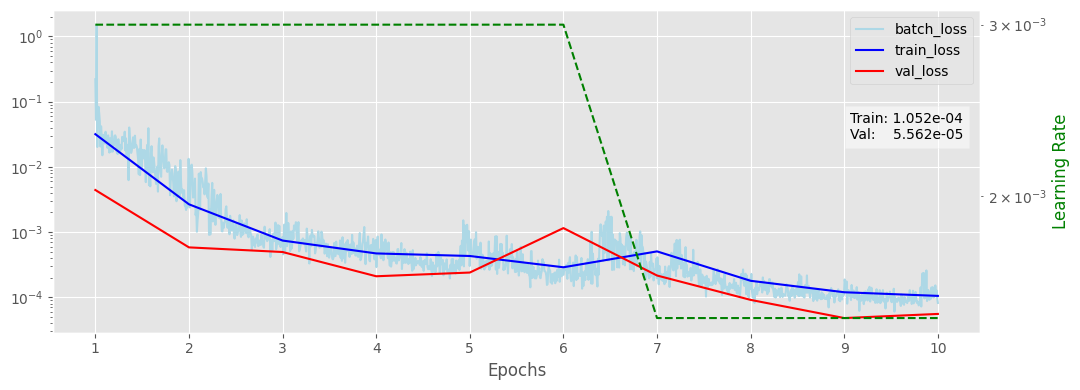

In [ ]:
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])
# Extract the 'Train Loss' column and compare with the train_losses list
train_loss_column = training_df['Train Loss'].replace(['',' '], np.nan).dropna().astype(float).values
if any(abs(train_loss_column - train_losses) > 1e-3):  print("Extracted and original Train Losses are not equal. Please check metrics table.")

# -------------------------------------
# plot training performance:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

assert len(train_losses_per_iter) == NUM_EPOCHS * len(train_loader), "Length of train_losses_per_iter might not match the number of iterations."
plt.plot(np.linspace(1, NUM_EPOCHS, len(train_losses_per_iter)), train_losses_per_iter, label='batch_loss', color='lightblue')
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss', color='red')

plt.yscale('log'); fig.tight_layout(); plt.legend();

plt.text(0.86, 0.6, f"Train: {train_losses[-1]:.3e}\nVal:    {val_losses[-1]:.3e}", \
    transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5));

if pd.Series(lr_history).nunique() > 1:
    ax2 = ax1.twinx()
    ax2.plot(range(1, NUM_EPOCHS + 1), lr_history, label='lr', color='green', linestyle='--')
    ax2.set_ylabel('Learning Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_yscale('log')


In [ ]:
# EVALUATION -----------------------------------------------------------------
# get file list of test subset
test_files = checkpoint["subset_files"]["test"]
# -------------------------------------
test_loss, outputs, targets, original_lengths = trainer.evaluate_model()
# -------------------------------------
all_outputs, all_targets, all_original_lengths = [], [], []
for batch_outputs, batch_targets, batch_lengths in zip(outputs, targets, original_lengths):
    all_outputs.extend(batch_outputs)
    all_targets.extend(batch_targets)
    all_original_lengths.extend(batch_lengths)

# Inverse-transform on all outputs and targets for evaluation
#scaled_outputs = target_scaler.inverse_transform(np.concatenate(all_outputs, axis=0).reshape(-1, 1))
#scaled_targets = target_scaler.inverse_transform(np.concatenate(all_targets, axis=0).reshape(-1, 1))

# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]


print(f"Test Loss:  {test_loss:.4f}")
print(f"RMSE: {root_mean_squared_error(np.concatenate(scaled_targets), np.concatenate(scaled_outputs)):.4f}")
print(f"Standard Deviation: {np.std(np.concatenate(scaled_targets) - np.concatenate(scaled_outputs)):.4f}")

Test Loss:  0.0001
RMSE: 0.8836
Standard Deviation: 0.7904


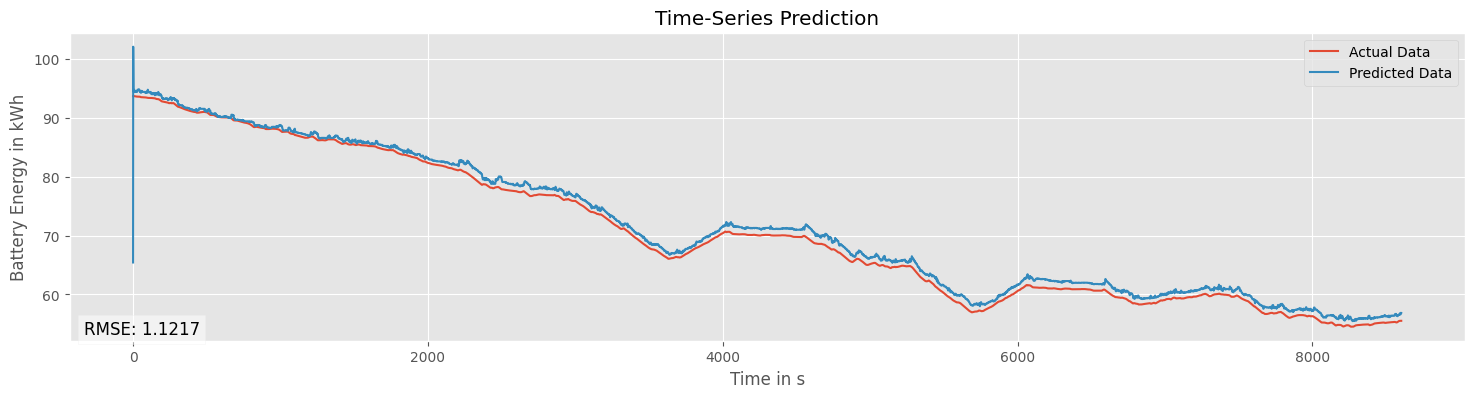

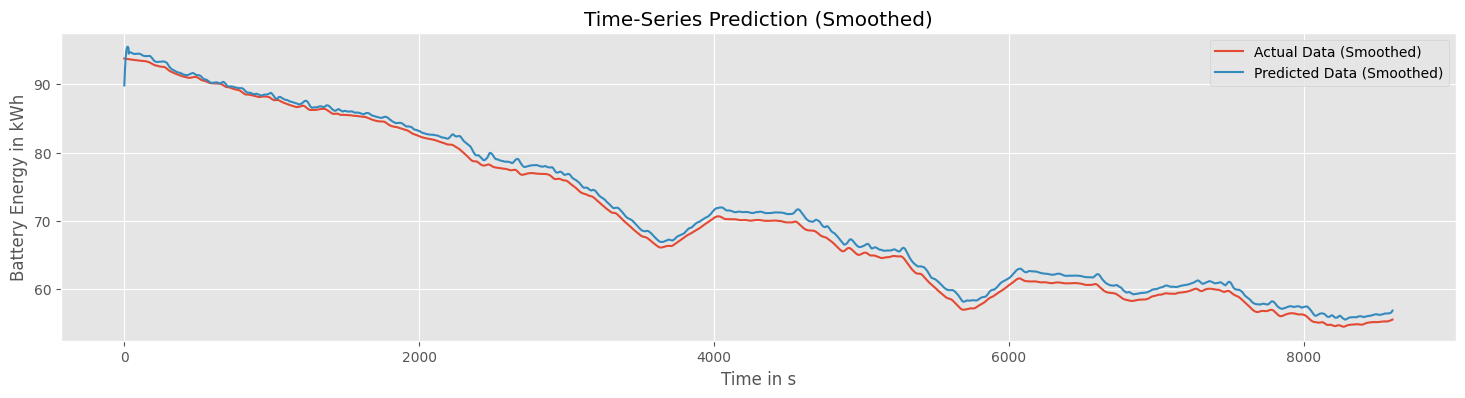

In [ ]:
# get random sample sequence from test set
# -------------------------------------
random_int = random.randint(1, len(scaled_outputs))
y_pred = scaled_outputs[random_int]
y_true = scaled_targets[random_int]
###############################################
# PLOT PREDICTION -----------------------------------------------------------------
plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction')
plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
plt.legend()
plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}", transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('Battery Energy in kWh'); plt.title('Time-Series Prediction (Smoothed)')
plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
plt.legend();

In [ ]:
'''
TODOs
    - check if any batch contains only one sequence. If so, discard it before training
''';